The following file demonstrates the differences between a simplex solver and a solver for (mixed) integer programming problems.  You can use the file for the following sequence of experiments:

1. Solve the problem with integer coefficients.  Do to this, comment out the code lines `In [6]` and `In [8]`.  Compute the solution with the IP solver (`within=NonNegativeIntegers` in box `In [9]` below).  Change to an LP solver (`within=NonNegativeReals` in box `In [9]` below).  Both should work well and give the same optimal cost (the given solutions, however, differ as the optimal flow is not unique.)

2. Keep the LP solver and switch to non-integer $b$.  To do so, un-comment code line `b = rand(size) + b`.  The solver will compute, just as easily, a non-integer solution.

3. Switch to the IP solver (revert to `within=NonNegativeIntegers`).  An integer solution will probably not exist, but the solver cannot "prove" this and will practically compute for ever.

4. With a high inflow offset, the integer solution will be the trivial solution.  Start, e.g., with `b += 5` below and reduce the offset in integer steps.  The solution will become more complex, optimal cost increases, and the compute time sharply increases.  This works until about `b += 1.9`, for lower values the compute time becomes impractical.

Some conclusions:

* When the LP and IP problem coincide (integrality property of network flow problems), both solvers are very effective.  (The IP solver in fact uses an LP solver to get lower bounds for the objective function on subbranches, so if the LP solver returns a feasible solution, the IP solver notices and returns.)

* When the problem has a noninteger optimal solution, the LP solver has no problem computing it.

* The IP solver, on the other hand, is extremely sensitive to solution structure and even small problems may not terminate in a finite time.  The behavior is hard to predict and may change dramatically with only very minor changes in the data.

The following line is a magical notebook command which imports the pylab environment and sets up inline plotting.  The warning can be ignored.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyomo.environ import *
from pyomo.opt import *
opt = solvers.SolverFactory("glpk")

In the following, we create a random network.  To make the simulation reproducable, we seed the random number generator.  All of the options explained below are tested with `seed(5)`, other values could change the behavior quite a bit.

In [3]:
seed (5)

We are implementing a Minimum Cost Flow Problem, where $b$ is the vector of inflows/outflows at each node of the network, $C$ is the matrix of costs for each arc (we assume a complete graph) and $U$ is the upper bound constraint for each arc, which may be zero.
All coefficients are initially taken to be integers.

In [4]:
size = 20

b = random_integers(0,10,size)
C = random_integers(1,3,(size,size))
U = random_integers(0,5,(size,size))

The following are the index set $N$ for the nodes and $A$ for the arcs.

In [5]:
N = arange(size, dtype=int)
A = [(i,j) for i in N for j in N]

If we want non-integer in/outflows, leave the following line uncommented.  For integer solutions, comment it out.

In [6]:
b = rand(size) + b

Let's make sure that the network is balanced, i.e. the sum of inflows equals the sum of outflows.  In a first step, we subtract the average from the flow on each node.  When we are operating in the reals, then this has the flow already balanced.  When we are operating in the integers, the flow may have a remaining imbalance due to rounding, which we remove in a second line.  (Note that even in the integer case, we perform both operations.  Doing only the second line would surely balance the flow, but typically lead to a rather non-uniform network.)

In [7]:
b -= mean(b) 
b[0] = -sum(b[1:])

When restricting the solution to the integers, a completely balanced network will typically not have a solution.  We thus add an inflow to all nodes in the network.  The higher the value, the "easier" it is for the solver to find solutions.  Thus, for an integer programming problem, the solution time will explode as this parameter is reduced to zero.  For the seeding set above, an offset of $1.9$ is just about what can be computed interactively.  Larger values make for a faster computation.  Smaller values will result in very long or practically infinite compute time.

In [8]:
b += 1.9

We now set up the model, where the decision variables $f_{i,j}$ represent the flow in each directed arc.  Change to `within = NonNegativeReals` for the standard LP problem. 

In [9]:
model = ConcreteModel()
model.f = Var(A, within=NonNegativeIntegers)

The rest is the setup for the Minimum Cost Flow Problem with one change: integer solutions for the $f_{i,j}$ with non-integer $b_i$ will typically not exist.  Therefore, we relax the flow rule to saying that the inflow should be no less than the outflow; we permit that excess flow is "discarded".

In [10]:
def capacity_rule(model, i, j):
    return model.f[i,j] <= U[i,j]

model.capacity = Constraint(A, rule=capacity_rule)

def flow_rule(model, n):
    InFlow  = sum(model.f[i,j] for (i,j) in A if j==n)
    OutFlow = sum(model.f[i,j] for (i,j) in A if i==n)
    return InFlow + b[n] >= OutFlow
    
model.flow = Constraint(N, rule=flow_rule)

model.cost = Objective(expr = sum(model.f[a]*C[a] for a in A), sense=minimize)

Now we solve and write the solution into a flow matrix $M$.  (There might be better ways of doing this, but the following works.)

In [11]:
results = opt.solve(model)

f = model.f.get_values()
M = zeros((size,size))
for (i,j) in A:
    M[i,j] = f[(i,j)]

Now use `imshow` to visually display the solution.  (The options do the following: switch off interpolation as we want to visualize the matrix as a discrete object, put the origin into the lower left corner, and choose an appropriate color map where zero corresponds to white.  We also draw a color bar.)

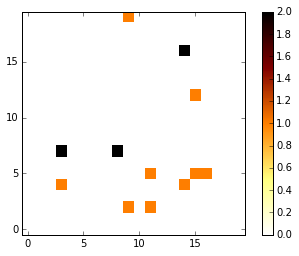

In [12]:
imshow(M, 
       interpolation='nearest',
       origin = 'lower',
       cmap = 'afmhot_r')
colorbar()

In [13]:
model.cost.expr()

16.0